# C5T3:  Build and Evaluate Models -- Customer Default Identification

Last update: 2018.10.28  
Updated by : Greg Hepguler

File: C5T3_Build_Evaluate_Models.ipynb

Project Notes:  
Credit One has seen an increase in the number of customers who have defaulted on loans.  
As the credit scoring service, they could lose business if the problem is not solved right away. 

In this task, we use Credit One historical data and demographics data to predict whether or not 
a customer is likely to default on their credit obligations.  

Python Script Goal:  
Examine feature selection and model building using the Python module Sci-Kit Learn. 

> 
> Import LIBRARIES

In [1]:
# Import libraries
import pandas as pd
from pandas import Series, DataFrame
import numpy  as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import scipy

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from matplotlib.pylab import *
from pylab import rc, rcParams
from math import sqrt

# Regression estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model

# Classification Models
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Normalization
from sklearn.preprocessing import StandardScaler

# RFE, Recursive Feature Elimination
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Evaluating the Classification Algorithm
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# Metrics
from sklearn import metrics
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score

import plotly.plotly as py
import plotly.tools as tls

In [2]:
#cross validation
#### from sklearn.cross_validation import train_test_split  #### >> Gives WARNING:
#  DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module 
#  into which all the refactored classes and functions are moved. 
#  Also note that the interface of the new CV iterators are different from that of this module. 
#  This module will be removed in 0.20.

from sklearn.model_selection import train_test_split

In [3]:
# Set default matplot figure size
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

MODELS

In [4]:
# Model Choice for Regression 
# modelSVR = SVR()
# modelRF = RandomForestRegressor()
# modelLR = LinearRegression()

IMPORT DATA 
> New .csv file containing pre-processed and cleaned data from EDA instead of the original

In [5]:
# Import Credit One payment and default data created after EDA
CreditOneEDA = pd.read_csv('C5T2_EDAresults_GregHepguler.csv', header =0)

In [6]:
# Make a copy of the Dataset before Feature Engineering
credit = CreditOneEDA.copy()

In [7]:
# view a sample of the dataframe 
credit.head()
# credit.tail()
# credit

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AgeBin,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,20,2,2,-1,-1,...,3913,689,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,20,-1,2,0,0,...,2682,2682,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,30,0,0,0,0,...,29239,13559,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,30,0,0,0,0,...,46990,49291,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,50,-1,0,-1,0,...,8617,35835,19131,2000,36681,10000,9000,689,679,0


In [8]:
# understand the makeup of the data
credit.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AgeBin,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,3.000000e+04,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,29.939000,-0.016700,-0.133767,-0.166200,-0.220667,...,51223.330900,4.701315e+04,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.584502,1.123802,1.197186,1.196868,1.169139,...,73635.860576,6.934939e+04,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,20.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-165580.000000,-1.572640e+05,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,20.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,3558.750000,2.666250e+03,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,30.000000,0.000000,0.000000,0.000000,0.000000,...,22381.500000,2.008850e+04,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,67091.000000,6.016475e+04,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,70.000000,8.000000,8.000000,8.000000,8.000000,...,964511.000000,1.664089e+06,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [9]:
credit['default payment next month'] = credit['default payment next month'].astype('category') 

In [10]:
# check the data types of each variable
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 22 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AgeBin                        30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT6                     30000 non-null int64
PAY_AMT1                      30000 non-null int64
PAY_AMT2                      30000 non-null int64
PAY_AMT3                

> VISUALIZING THE DATA

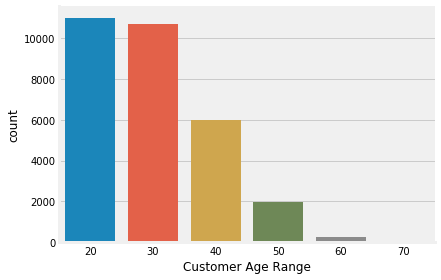

In [11]:
# Use seaborn to plot the number of Customers in each AgeBin
fg = sns.factorplot('AgeBin', data=credit, kind='count', aspect=1.5)
fg.set_xlabels('Customer Age Range')

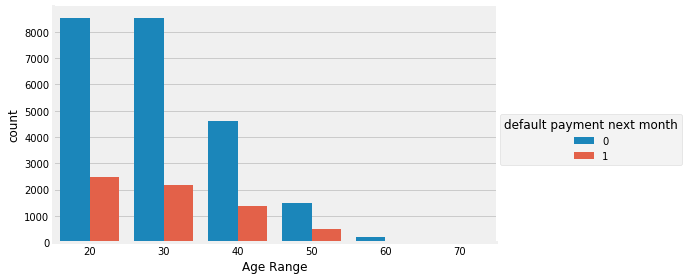

In [12]:
# Again use saeborn to group by Age Range and default payment
g = sns.factorplot('AgeBin', data=credit, hue='default payment next month', kind='count', aspect=1.75)
g.set_xlabels('Age Range')

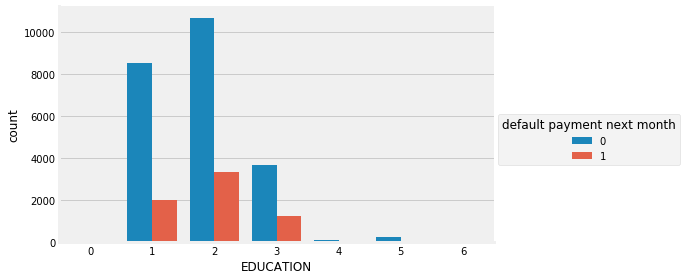

In [13]:
# Again use saeborn to group by Age Range and default payment
g = sns.factorplot('EDUCATION', data=credit, hue='default payment next month', kind='count', aspect=1.75)
g.set_xlabels('EDUCATION')

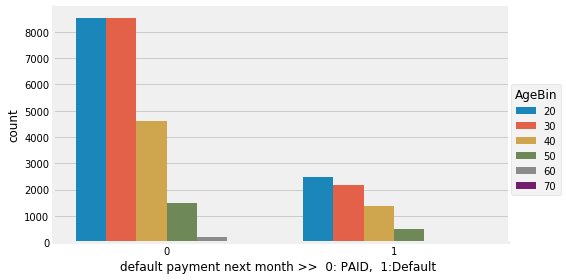

In [14]:
# Use saeborn to group by Sex and class
g = sns.factorplot('default payment next month', data=credit, hue='AgeBin', kind='count', aspect=1.75)
g.set_xlabels('default payment next month >>  0: PAID,  1:Default ')

> FEATURE ENGINEERING
>> CORRELATION MATRIX, CM

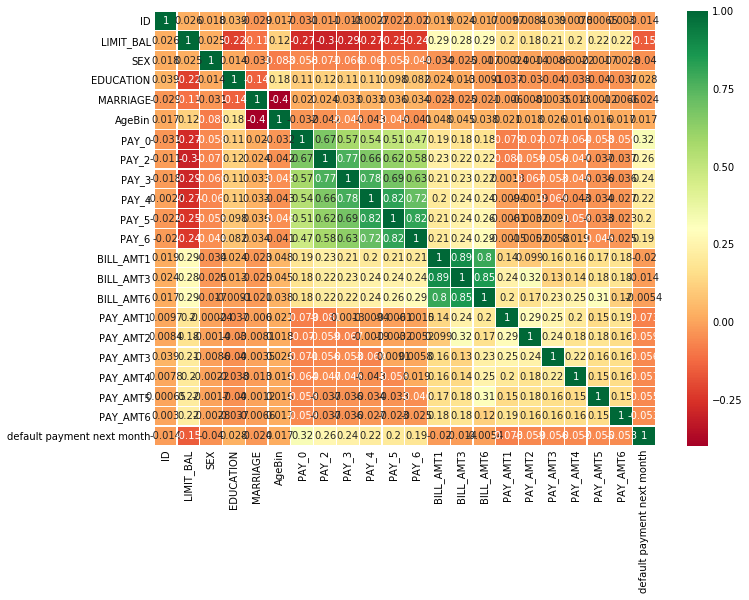

In [15]:
# Verify highly correlated variables, Corr-Coeff > 0.90
# credit_corr = CreditOneEDA.copy() 
# Correlation between features  ## All Features must be INT64 to Get Redundant Pairs ##  
sns.heatmap(CreditOneEDA.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

>> Verify No Highly Correlated Variables (corr coefficient above 0.90) after EDA

In [16]:
def get_redundant_pairs(credit):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = CreditOneEDA.columns
    for i in range(0, credit.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):                ## All Features must be INT64
    au_corr = CreditOneEDA.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(CreditOneEDA)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(CreditOneEDA, 5))

Top Absolute Correlations
BILL_AMT1  BILL_AMT3    0.892279
BILL_AMT3  BILL_AMT6    0.853320
PAY_4      PAY_5        0.819835
PAY_5      PAY_6        0.816900
BILL_AMT1  BILL_AMT6    0.802650
dtype: float64


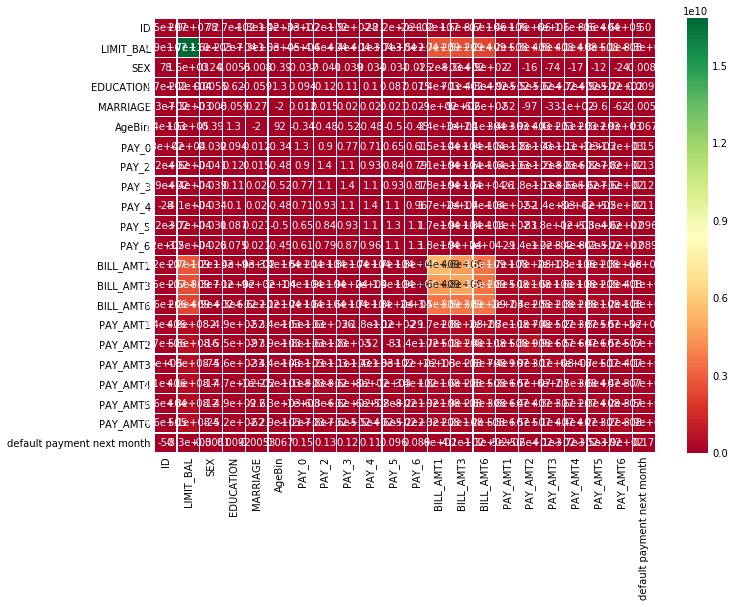

In [17]:
# Covariance
covMat = CreditOneEDA.cov()
# print(covMat)

sns.heatmap(covMat,annot=True,cmap='RdYlGn',linewidths=0.2) 
# sns.heatmap(CreditOneEDA.cov(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

>> FEATURES after EDA

In [18]:
# Features after EDA   ## Column names ##
CreditOneEDA.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AgeBin,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,20,2,2,-1,-1,...,3913,689,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,20,-1,2,0,0,...,2682,2682,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,30,0,0,0,0,...,29239,13559,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,30,0,0,0,0,...,46990,49291,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,50,-1,0,-1,0,...,8617,35835,19131,2000,36681,10000,9000,689,679,0


> FEATURE ENGINEERING  
>> RFE, Recursive Feature Elimination

In [19]:
# Get random SAMPLE of Dataset
seed = 101
Subset_fraction = CreditOneEDA.sample(frac=0.20, random_state=seed)
Subset_fraction.info()
# Subset_fraction
# Subset_fraction.head()
Subset_fraction.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 6015 to 14866
Data columns (total 22 columns):
ID                            6000 non-null int64
LIMIT_BAL                     6000 non-null int64
SEX                           6000 non-null int64
EDUCATION                     6000 non-null int64
MARRIAGE                      6000 non-null int64
AgeBin                        6000 non-null int64
PAY_0                         6000 non-null int64
PAY_2                         6000 non-null int64
PAY_3                         6000 non-null int64
PAY_4                         6000 non-null int64
PAY_5                         6000 non-null int64
PAY_6                         6000 non-null int64
BILL_AMT1                     6000 non-null int64
BILL_AMT3                     6000 non-null int64
BILL_AMT6                     6000 non-null int64
PAY_AMT1                      6000 non-null int64
PAY_AMT2                      6000 non-null int64
PAY_AMT3                      6000 non-

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AgeBin,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
24667,24668,200000,1,1,1,40,-2,-2,-2,-2,...,10799,1585,1000,1213,1585,1470,1273,1000,1555,0
1752,1753,60000,2,2,1,30,-2,-2,-2,-2,...,4764,0,41404,30500,0,0,52829,41404,22401,0
12896,12897,380000,2,2,2,20,0,0,-1,0,...,4400,270219,3791,0,270219,131,135,136,76,0
13432,13433,30000,2,1,2,30,0,0,2,0,...,14254,15908,0,2890,0,321,6501,0,0,1
14866,14867,420000,1,1,1,50,0,0,0,0,...,195379,200431,205082,8003,7529,10005,8015,10018,7715,0


In [20]:
print("Columns  ", len(CreditOneEDA.columns))
# print(CreditOneEDA.count)
print("Observations in Credit One EDA dataset:  ", CreditOneEDA.shape[0])
print("Observations in RFE dataset:  ", Subset_fraction.shape[0])

Columns   22
Observations in Credit One EDA dataset:   30000
Observations in RFE dataset:   6000


Optimal number of features : 11
Selected Features: [False  True  True False  True False False  True False False  True  True
  True  True  True False False False  True  True False]
Feature Ranking: [ 7  1  1  9  1 11  6  1  8  4  1  1  1  1  1  5 10  2  1  1  3]


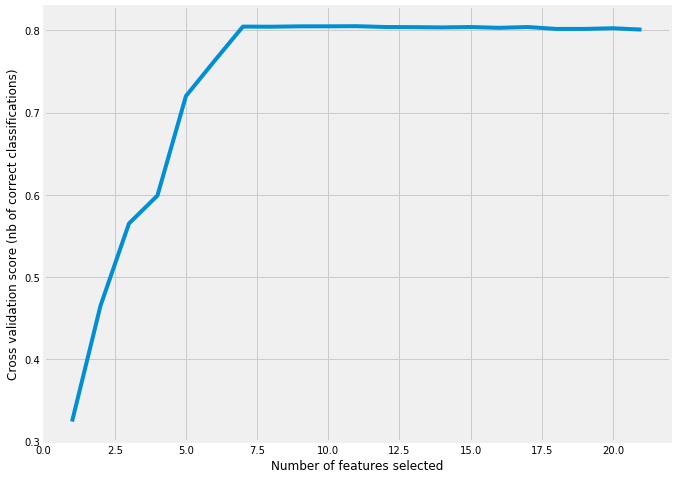

In [21]:
# Build a classification task

# X_train, y_train = make_classification(n_samples=y_train_count, n_features=20, n_informative=3,
#                            n_redundant=2, n_repeated=0, n_classes=5,
#                           n_clusters_per_class=1, random_state=0)
y_train_count = Subset_fraction.shape[0]
X_train, y_train = make_classification(n_samples=y_train_count, n_features=21, n_informative=7,
                           n_redundant=4, n_repeated=0, n_classes=5,
                           n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
RFE_model = SVC(kernel="linear")

# Option to try another RFE model
# RFE_model = LogisticRegression()

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=RFE_model, step=1, cv=StratifiedKFold(5),
              scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
print(("Selected Features: %s") % rfecv.support_)
print(("Feature Ranking: %s") % rfecv.ranking_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [22]:
# Get idxs of columns to keep
idxs_selected = rfecv.get_support(indices=True)
# Create new dataframe with only desired columns, or overwrite existing
features_dataframe_new = rfecv.get_support(indices=True)
features_dataframe_newolname = Subset_fraction.columns[features_dataframe_new]

In [23]:
# Feature column names after RFE results
colname = Subset_fraction.columns[features_dataframe_new]
# print (colname)
colname = np.append(colname, ['default payment next month'])
colname

array(['LIMIT_BAL', 'SEX', 'MARRIAGE', 'PAY_2', 'PAY_5', 'PAY_6',
       'BILL_AMT1', 'BILL_AMT3', 'BILL_AMT6', 'PAY_AMT4', 'PAY_AMT5',
       'default payment next month'], dtype=object)

In [24]:
# RFE results to a new dataframe
RFEresults = Subset_fraction[colname]
# RFEresults.head()
RFEresults.tail()

,LIMIT_BAL,SEX,MARRIAGE,PAY_2,PAY_5,PAY_6,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT4,PAY_AMT5,default payment next month
24667,200000,1,1,-2,-2,-2,10799,1585,1000,1273,1000,0
1752,60000,2,1,-2,-2,-2,4764,0,41404,52829,41404,0
12896,380000,2,2,0,0,0,4400,270219,3791,135,136,0
13432,30000,2,2,0,-1,-1,14254,15908,0,6501,0,1
14866,420000,1,1,0,0,0,195379,200431,205082,8015,10018,0


>  SUBSETs of Original DataSet
>> EDA Dataset ----  Use Features remaining after EDA, CM  ----

In [25]:
# Get random SAMPLE of Dataset for MODELS
# seed = 101
# Subset_fraction = CreditOneEDA.sample(frac=0.20, random_state=seed)
# Subset_fraction.info()
# Subset_fraction
# Subset_fraction.head()
Subset_fraction.tail()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AgeBin,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
24667,24668,200000,1,1,1,40,-2,-2,-2,-2,...,10799,1585,1000,1213,1585,1470,1273,1000,1555,0
1752,1753,60000,2,2,1,30,-2,-2,-2,-2,...,4764,0,41404,30500,0,0,52829,41404,22401,0
12896,12897,380000,2,2,2,20,0,0,-1,0,...,4400,270219,3791,0,270219,131,135,136,76,0
13432,13433,30000,2,1,2,30,0,0,2,0,...,14254,15908,0,2890,0,321,6501,0,0,1
14866,14867,420000,1,1,1,50,0,0,0,0,...,195379,200431,205082,8003,7529,10005,8015,10018,7715,0


>> Define FEATURES and DEPENDENT Variable   
>> Select TRAINING and TEST dataset for Cross Validation

In [26]:
# Set Features from EDA dataset
features = Subset_fraction.iloc[:,1:21]
print('Summary of feature sample')
# features
features.head()

Summary of feature sample


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AgeBin,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
6015,60000,2,2,1,40,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0
28660,60000,2,3,2,40,0,0,0,0,0,0,56403,59198,33591,2300,2600,1600,1200,2000,1300
12498,50000,1,3,1,40,0,0,0,0,-1,-1,45600,7857,780,1800,1506,6,2430,780,0
22957,50000,2,3,1,40,0,0,0,0,0,0,50411,42248,29660,5000,2000,2500,2500,2000,2500
14848,130000,1,2,2,20,0,0,0,0,0,0,116646,110317,104253,5578,4000,3863,3831,4136,5385


In [27]:
# Dependent Variable
depVar = Subset_fraction['default payment next month']
# print(depVar)
# depVar.head()
depVar.tail()

24667    0
1752     0
12896    0
13432    1
14866    0
Name: default payment next month, dtype: int64

In [28]:
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(features, depVar, test_size=test_size, 
                                                    random_state=101)

# Features (independent variables) in Training Set (X Training)
X_train_count = len(X_train.index)
print('The number of observations in the X training set are:',str(X_train_count))
X_train.head()

The number of observations in the X training set are: 4200


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AgeBin,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
1771,50000,2,3,1,50,0,0,0,0,0,0,33197,28913,29506,2407,2960,1029,1059,1073,1200
22727,280000,2,4,1,40,-2,-2,-2,-2,-2,-2,5374,20721,17131,12360,20721,0,0,17131,2681
25251,290000,2,2,2,20,0,0,0,0,0,0,57445,46484,24004,2000,1800,1400,1000,1000,1000
9465,50000,2,2,1,30,0,0,2,0,0,0,11367,10243,10146,3000,1000,1000,1000,2000,2000
2051,50000,1,3,2,20,2,2,2,2,2,2,54529,53782,49062,1800,3900,300,3400,0,4000


In [29]:
# Dependent Variable Training Set (y Training)
y_train_count = len(y_train.index)
print('The number of observations in the Y training set are:',str(y_train_count))
y_train.head()

The number of observations in the Y training set are: 4200


1771     0
22727    1
25251    0
9465     0
2051     0
Name: default payment next month, dtype: int64

In [30]:
#Testing Set (X Testing)
X_test_count = len(X_test.index)
print('The number of observations in the feature testing set is:',str(X_test_count))
print(X_test.head())

The number of observations in the feature testing set is: 1800
       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AgeBin  PAY_0  PAY_2  PAY_3  \
939       200000    2          2         1      30     -1     -1     -1   
24493     170000    1          2         2      30      1     -2     -1   
19563     230000    2          1         2      30     -1     -1     -1   
26860     230000    1          1         1      30     -2     -2     -2   
15264     230000    2          2         2      30      1     -2     -2   

       PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT3  BILL_AMT6  PAY_AMT1  \
939       -1     -1     -1       5150      10190      11193     10190   
24493      2      2     -2      -1000       1000          0         0   
19563     -1     -1     -1       3251       2557       6059      4347   
26860     -2     -2     -2       7904         -3         -3       864   
15264     -1     -1     -1        -46        -46       1788         0   

       PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  

In [31]:
#Ground Truth (y_test) 
y_test_count = len(y_test.index)
print('The number of observations in the Y Testing set are:',str(y_test_count))
y_test.head()

The number of observations in the Y Testing set are: 1800


939      0
24493    0
19563    1
26860    0
15264    1
Name: default payment next month, dtype: int64

> COMPARE MODELS ---- TRAINING and PREDICTIONS
>> Out of Box    ---- EDA Dataset

In [32]:
# random number seed
seed = 101

# prepare models
models = []
# models.append(('LR', LogisticRegression()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RFC', RandomForestClassifier()))
               
# Evaluate each model in turn  -- 13.2. Compare Machine Learning Algorithms Consistently 85 --
# 10 fold Cross validation
results = []
presults = []
names = []
mscores = []
scoring = 'accuracy'

# MODEL Accuracy from Cross validation
print("MODEL Cross-Validation Accuracy and STD")
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, 100*cv_results.mean(), cv_results.std())
    print(msg)

print("\nMODEL Scores")
for name, model in models:
    model.fit(X_train, y_train)
    Model_score = model.score(X_train,y_train)
    mscores.append(Model_score)
    # names.append(name)
    msg_fit = "%s: %f " % (name, 100*Model_score)
    print(msg_fit)
    
# PREDICTION
print("\nMODEL Prediction Accuracy")
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 
    Predict_results = model.score(X_test, y_test)
    presults.append(Predict_results)
    msg = "%s: %f " % (name, 100*Predict_results)
    print(msg)
    


MODEL Cross-Validation Accuracy and STD
KNN: 74.785714 (0.025365)
SVM: 77.690476 (0.016532)
RFC: 80.142857 (0.012335)

MODEL Scores
KNN: 81.214286 
SVM: 99.619048 
RFC: 98.071429 

MODEL Prediction Accuracy
KNN: 73.833333 
SVM: 79.000000 
RFC: 81.722222 


[Text(0,0,'KNN'), Text(0,0,'SVM'), Text(0,0,'RFC')]

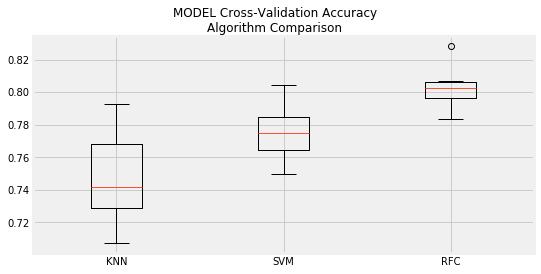

In [33]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(8, 4))
fig.suptitle('MODEL Cross-Validation Accuracy\nAlgorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)


Text(0,0.5,'Prediction Accuracy')

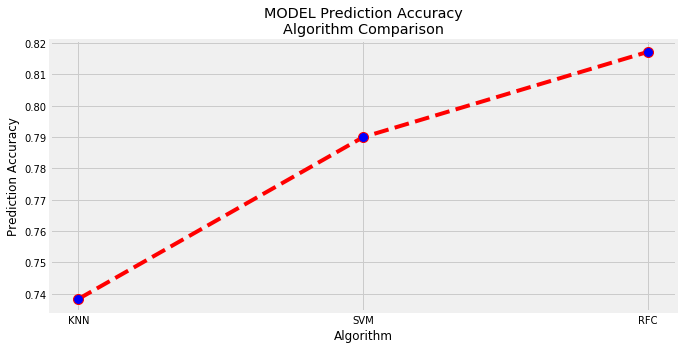

In [34]:
plt.figure(figsize=(10, 5)) 
plt.plot(names, presults, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.xticks(names)
plt.title('MODEL Prediction Accuracy\nAlgorithm Comparison')  
plt.xlabel('Algorithm')  
plt.ylabel('Prediction Accuracy')  

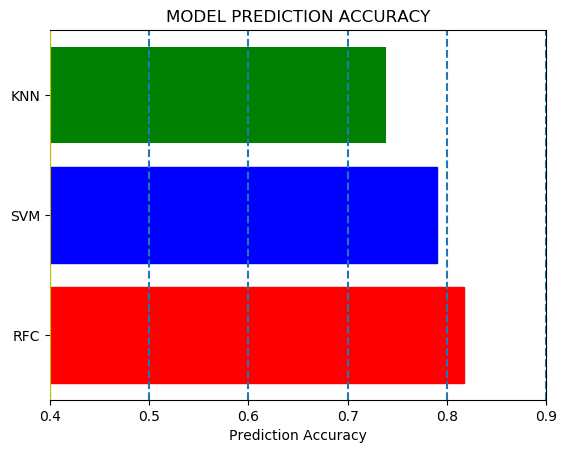

In [35]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Horizontal BarPlot Data
y_pos = np.arange(len(names))
performance = presults

ax.barh(y_pos, performance, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Prediction Accuracy')
ax.set_title('MODEL PREDICTION ACCURACY')

valueX = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
plt.xticks(valueX)

#bottom
ax.get_children()[1].set_color('b')
ax.get_children()[2].set_color('r')
ax.get_children()[3].set_color('y')

# X-grid lines
for xmaj in ax.xaxis.get_majorticklocs():
  ax.axvline(x=xmaj, ls='--')

plt.xlim((0.4, 0.9))

plt.show()


> TUNING THE MODELS
>> kNN   ---- EDA Dataset

In [36]:
# class sklearn.neighbors.
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, 
#                      p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)
# weights : str or callable, optional (default = ‘uniform’)
# weight function used in prediction. Possible values:
#    ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
#   ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

# TRAINING
classifier_kNN = KNeighborsClassifier()    # Out of Box kNN claasification
                                           # weight='uniform'
# kNN using 10-fold Cross Validation
num_folds = 10
seed = 101
kfold = KFold(n_splits=num_folds, random_state=seed)

CVresults = cross_val_score(classifier_kNN, X_train, y_train, cv=kfold)
print("\nCross Validation Score: ", "\n", CVresults)

# print("Accuracy: ", results.mean()*100.0, results.std()*100.0)
print("\nCross Validation Results: ", 
      "Accuracy  and  STD ", "{0:.2f}".format(round(CVresults.mean()*100,2)),"% and ",
      "{0:.2f}".format(round(CVresults.std()*100,2)))

# FIT MODEL
classifier_kNN.fit(X_train, y_train)
TrainResults = classifier_kNN.score(X_train, y_train)
print("\nTRAINING KNN Model Score: ",  
      "{0:.2f}".format(round(TrainResults*100,2)),"%")


Cross Validation Score:  
 [0.76666667 0.73095238 0.77380952 0.74761905 0.70714286 0.72619048
 0.72857143 0.76904762 0.79285714 0.73571429]

Cross Validation Results:  Accuracy  and  STD  74.79 % and  2.54

TRAINING KNN Model Score:  81.21 %


In [37]:
# PREDICTIONS on test data
y_pred = classifier_kNN.predict(X_test)   

# Evaluating the algorithm
print("\n", "Confusion Matrix: ", "\n", confusion_matrix(y_test, y_pred))  
print("\n", "Classification Report:  ", "\n", classification_report(y_test, y_pred))

# Prediction
Pred_kNN_result = classifier_kNN.score(X_test, y_test)
print("Prediction Accuracy: ", "{0:.2f}".format(round(Pred_kNN_result*100,2)))


 Confusion Matrix:  
 [[1271  150]
 [ 321   58]]

 Classification Report:   
              precision    recall  f1-score   support

          0       0.80      0.89      0.84      1421
          1       0.28      0.15      0.20       379

avg / total       0.69      0.74      0.71      1800

Prediction Accuracy:  73.83


>> Plot kNN Accuracy

Text(0,0.5,'Accuracy')

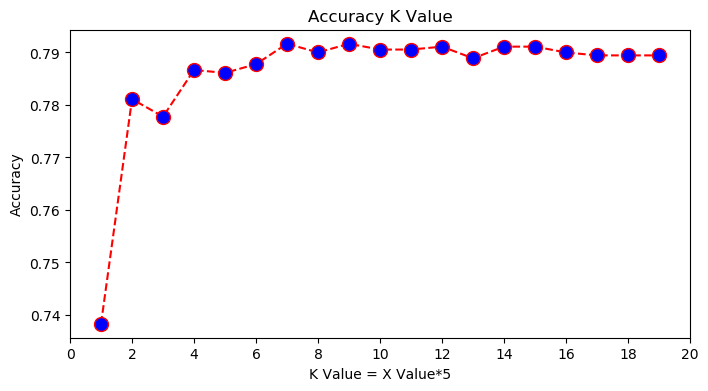

In [38]:
error = []
acc = []

# Calculating error for K values between 1 and 100
for i in range(1, 20):
    param = i*5
    knn = KNeighborsClassifier(n_neighbors=param)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    # error.append(np.mean(pred_i != y_test))
    error.append(knn.score(X_test, y_test))
    # Prediction
    # Pred_kNN_result = knn.score(X_test, y_test)
    # acc.append(Pred_kNN_result) 
               
# plt.figure(figsize=(10, 5))
plt.figure(figsize=(8, 4))
plt.plot(range(1, 20), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
valueX = [0,2,4,6,8,10,12,14,16,18,20]
plt.xticks(valueX)
plt.title('Accuracy K Value')  
plt.xlabel('K Value = X Value*5')  
plt.ylabel('Accuracy')


In [39]:
# print("Prediction Accuracy: ", error)
Best1 = np.max(error)
value_index = error.index(Best1)
# print(Best1, value_index)
print("Max Prediction Accuracy: ", "{0:.2f}".format(round(Best1*100,2)), "%  at K Value = ", (value_index+1)*5)

Max Prediction Accuracy:  79.17 %  at K Value =  35


>> kNN using K=35 and weights='uniform'

In [40]:
# kNN using ---- K=35 and  weights='uniform' ----
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, 
#                      p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)
# TRAINING
classifier_kNN = KNeighborsClassifier(n_neighbors=35, weights='uniform', algorithm='auto', 
                                      leaf_size=30, p=2, metric='minkowski')                             

# kNN using 10-fold Cross Validation
num_folds = 10
seed = 101
kfold = KFold(n_splits=num_folds, random_state=seed)

CVresults = cross_val_score(classifier_kNN, X_train, y_train, cv=kfold)
print("\nCross Validation Score: ", "\n", CVresults)

# print("Accuracy: ", results.mean()*100.0, results.std()*100.0)
print("\nCross Validation Results: ", 
      "Accuracy  and  STD ", "{0:.2f}".format(round(CVresults.mean()*100,2)),"% and ",
      "{0:.2f}".format(round(CVresults.std()*100,2)))

# FIT MODEL
classifier_kNN.fit(X_train, y_train)
TrainResults = classifier_kNN.score(X_train, y_train)
print("\nTRAINING KNN Model Score: ",  
      "{0:.2f}".format(round(TrainResults*100,2)),"%")


Cross Validation Score:  
 [0.8047619  0.78809524 0.77619048 0.7452381  0.75714286 0.76190476
 0.76904762 0.76904762 0.8        0.77380952]

Cross Validation Results:  Accuracy  and  STD  77.45 % and  1.77

TRAINING KNN Model Score:  77.79 %


>> kNN using K=35 and weights='distance'

In [41]:
# kNN using ---- K=35 and  weights='distance' ----
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, 
#                      p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)
# TRAINING
classifier_kNN = KNeighborsClassifier(n_neighbors=35, weights='distance', algorithm='auto', 
                                      leaf_size=30, p=2, metric='minkowski')                             

# kNN using 10-fold Cross Validation
num_folds = 10
seed = 101
kfold = KFold(n_splits=num_folds, random_state=seed)

CVresults = cross_val_score(classifier_kNN, X_train, y_train, cv=kfold)
print("\nCross Validation Score: ", "\n", CVresults)

# print("Accuracy: ", results.mean()*100.0, results.std()*100.0)
print("\nCross Validation Results: ", 
      "Accuracy  and  STD ", "{0:.2f}".format(round(CVresults.mean()*100,2)),"% and ",
      "{0:.2f}".format(round(CVresults.std()*100,2)))

# FIT MODEL
classifier_kNN.fit(X_train, y_train)
TrainResults = classifier_kNN.score(X_train, y_train)
print("\nTRAINING KNN Model Score: ",  
      "{0:.2f}".format(round(TrainResults*100,2)),"%")


Cross Validation Score:  
 [0.80238095 0.78571429 0.77142857 0.7452381  0.76190476 0.7547619
 0.76666667 0.77380952 0.7952381  0.76666667]

Cross Validation Results:  Accuracy  and  STD  77.24 % and  1.68

TRAINING KNN Model Score:  99.93 %


> TUNING THE MODELS
>> SVM Classification ---- EDA Dataset

In [42]:
# Tune SVM
seed = 101
num_folds = 5
# Tune scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()

kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

In [43]:
# Print SVM results
print("Best SVM CV-Score and Tuning Parameters", (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean CV score, STD, Params:", (mean, stdev, param))

Best SVM CV-Score and Tuning Parameters (0.8204761904761905, {'C': 0.9, 'kernel': 'rbf'})
Mean CV score, STD, Params: (0.8088095238095238, 0.013333333333333348, {'C': 0.1, 'kernel': 'linear'})
Mean CV score, STD, Params: (0.7830952380952381, 0.013456067762804553, {'C': 0.1, 'kernel': 'poly'})
Mean CV score, STD, Params: (0.8004761904761905, 0.010978230365141438, {'C': 0.1, 'kernel': 'rbf'})
Mean CV score, STD, Params: (0.7876190476190477, 0.013772528441885295, {'C': 0.1, 'kernel': 'sigmoid'})
Mean CV score, STD, Params: (0.8085714285714286, 0.013371543887713321, {'C': 0.3, 'kernel': 'linear'})
Mean CV score, STD, Params: (0.7914285714285715, 0.014704188244423329, {'C': 0.3, 'kernel': 'poly'})
Mean CV score, STD, Params: (0.8092857142857143, 0.012289036095775181, {'C': 0.3, 'kernel': 'rbf'})
Mean CV score, STD, Params: (0.7747619047619048, 0.016120296076010263, {'C': 0.3, 'kernel': 'sigmoid'})
Mean CV score, STD, Params: (0.809047619047619, 0.013312057855708933, {'C': 0.5, 'kernel': 'li

> TUNING THE MODELS
>> Random Forest Classification ---- EDA Dataset

In [45]:
# RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, min_samples_split=2, 
#                        min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, 
#                        max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
#                        bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
#                        warm_start=False, class_weight=None)

# clf = RandomForestClassifier(n_estimators=10, max_depth=None, 
#                              min_samples_split=2, random_state=0, verbose=1)
seed = 101
num_folds = 5

# scaler = StandardScaler().fit(X_train)
# rescaledX = scaler.transform(X_train)
# n_values = [2, 10, 25, 50, 100]
n_values = [2, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200, 500]
maxfeature_values = ['auto', 'log2']
param_grid = dict(n_estimators=n_values, max_features=maxfeature_values)
model = RandomForestClassifier()

kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

In [46]:
# Print RF Classifier results
print("Best RF Classifier CV-Score and Tuning Parameters", (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("CVscore, std, Parameters:", (mean, stdev, param))

Best RF Classifier CV-Score and Tuning Parameters (0.8183333333333334, {'max_features': 'log2', 'n_estimators': 500})
CVscore, std, Parameters: (0.7811904761904762, 0.012517561360090393, {'max_features': 'auto', 'n_estimators': 2})
CVscore, std, Parameters: (0.8014285714285714, 0.0082272154967481, {'max_features': 'auto', 'n_estimators': 10})
CVscore, std, Parameters: (0.805, 0.00815801985667231, {'max_features': 'auto', 'n_estimators': 15})
CVscore, std, Parameters: (0.8085714285714286, 0.005604096331399895, {'max_features': 'auto', 'n_estimators': 20})
CVscore, std, Parameters: (0.8145238095238095, 0.0017496355305594068, {'max_features': 'auto', 'n_estimators': 30})
CVscore, std, Parameters: (0.8126190476190476, 0.0020756661635907897, {'max_features': 'auto', 'n_estimators': 40})
CVscore, std, Parameters: (0.814047619047619, 0.006272352320152116, {'max_features': 'auto', 'n_estimators': 50})
CVscore, std, Parameters: (0.815952380952381, 0.007773727484435495, {'max_features': 'auto', 

>  SUBSETs of Original DataSet
>> RFE dataset

In [47]:
# Select Features from EDA dataset
features = RFEresults.iloc[:,:11]
print('Summary of feature sample')
# features
features.head()

Summary of feature sample


,LIMIT_BAL,SEX,MARRIAGE,PAY_2,PAY_5,PAY_6,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT4,PAY_AMT5
6015,60000,2,1,-2,-2,-2,0,0,0,0,0
28660,60000,2,2,0,0,0,56403,59198,33591,1200,2000
12498,50000,1,1,0,-1,-1,45600,7857,780,2430,780
22957,50000,2,1,0,0,0,50411,42248,29660,2500,2000
14848,130000,1,2,0,0,0,116646,110317,104253,3831,4136


In [48]:
# Dependent Variable
depVar = RFEresults['default payment next month']
# print(depVar)
# depVar.head()
depVar.tail()

24667    0
1752     0
12896    0
13432    1
14866    0
Name: default payment next month, dtype: int64

In [49]:
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(features, depVar, test_size=test_size, 
                                                    random_state=101)

# Features (independent variables) in Training Set (X Training)
X_train_count = len(X_train.index)
print('The number of observations in the X training set are:',str(X_train_count))
X_train.head()

The number of observations in the X training set are: 4200


,LIMIT_BAL,SEX,MARRIAGE,PAY_2,PAY_5,PAY_6,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT4,PAY_AMT5
1771,50000,2,1,0,0,0,33197,28913,29506,1059,1073
22727,280000,2,1,-2,-2,-2,5374,20721,17131,0,17131
25251,290000,2,2,0,0,0,57445,46484,24004,1000,1000
9465,50000,2,1,0,0,0,11367,10243,10146,1000,2000
2051,50000,1,2,2,2,2,54529,53782,49062,3400,0


In [50]:
# Dependent Variable Training Set (y Training)
y_train_count = len(y_train.index)
print('The number of observations in the Y training set are:',str(y_train_count))
y_train.head()

The number of observations in the Y training set are: 4200


1771     0
22727    1
25251    0
9465     0
2051     0
Name: default payment next month, dtype: int64

In [51]:
#Testing Set (X Testing)
X_test_count = len(X_test.index)
print('The number of observations in the feature testing set is:',str(X_test_count))
print(X_test.head())

#Ground Truth (y_test) 
y_test_count = len(y_test.index)
print('The number of observations in the Y Testing set are:',str(y_test_count))
y_test.head()

The number of observations in the feature testing set is: 1800
       LIMIT_BAL  SEX  MARRIAGE  PAY_2  PAY_5  PAY_6  BILL_AMT1  BILL_AMT3  \
939       200000    2         1     -1     -1     -1       5150      10190   
24493     170000    1         2     -2      2     -2      -1000       1000   
19563     230000    2         2     -1     -1     -1       3251       2557   
26860     230000    1         1     -2     -2     -2       7904         -3   
15264     230000    2         2     -2     -1     -1        -46        -46   

       BILL_AMT6  PAY_AMT4  PAY_AMT5  
939        11193     10594     11193  
24493          0         0         0  
19563       6059      4832      6314  
26860         -3         0         0  
15264       1788      4829      1788  
The number of observations in the Y Testing set are: 1800


939      0
24493    0
19563    1
26860    0
15264    1
Name: default payment next month, dtype: int64

> COMPARE MODELS --- RFE Dataset---

In [52]:
# random number seed
seed = 101

# prepare models
models = []
# models.append(('LR', LogisticRegression()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RFC', RandomForestClassifier()))
               
# Evaluate each model in turn  -- 13.2. Compare Machine Learning Algorithms Consistently 85 --
# 10 fold Cross validation
results = []
presults = []
names = []
mscores = []
scoring = 'accuracy'

# MODEL Accuracy from Cross validation
print("MODEL Cross-Validation Accuracy and STD")
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, 100*cv_results.mean(), cv_results.std())
    print(msg)

print("\nMODEL Scores")
for name, model in models:
    model.fit(X_train, y_train)
    Model_score = model.score(X_train,y_train)
    mscores.append(Model_score)
    # names.append(name)
    msg_fit = "%s: %f " % (name, 100*Model_score)
    print(msg_fit)
    
# PREDICTION
print("\nMODEL Prediction Accuracy")
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 
    Predict_results = model.score(X_test, y_test)
    presults.append(Predict_results)
    msg = "%s: %f " % (name, 100*Predict_results)
    print(msg)
    

MODEL Cross-Validation Accuracy and STD
KNN: 74.714286 (0.022075)
SVM: 77.880952 (0.017800)
RFC: 77.380952 (0.017722)

MODEL Scores
KNN: 81.309524 
SVM: 99.261905 
RFC: 97.476190 

MODEL Prediction Accuracy
KNN: 73.666667 
SVM: 78.888889 
RFC: 78.666667 


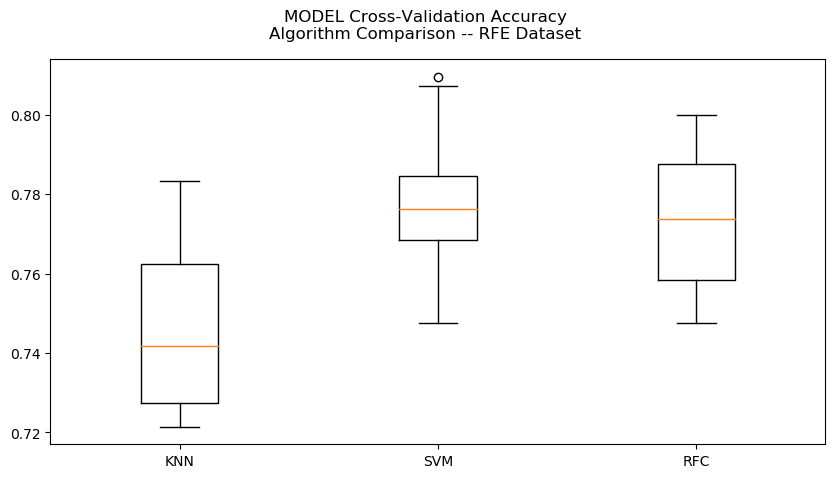

In [53]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 5))
fig.suptitle('MODEL Cross-Validation Accuracy\nAlgorithm Comparison -- RFE Dataset')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

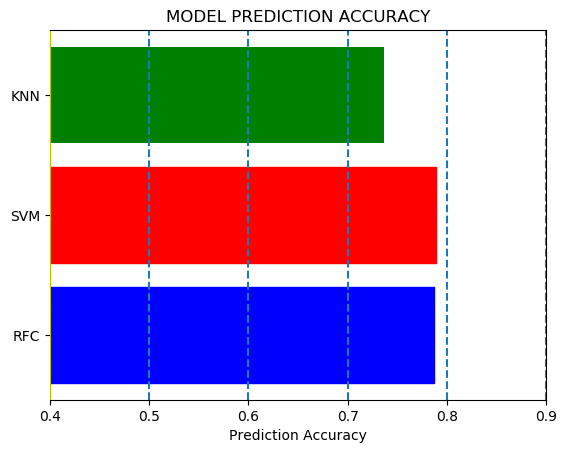

In [55]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Horizontal BarPlot Data
y_pos = np.arange(len(names))
performance = presults

ax.barh(y_pos, performance, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Prediction Accuracy')
ax.set_title('MODEL PREDICTION ACCURACY')

valueX = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
plt.xticks(valueX)

#bottom
ax.get_children()[1].set_color('r')
ax.get_children()[2].set_color('b')
ax.get_children()[3].set_color('y')

# X-grid lines
for xmaj in ax.xaxis.get_majorticklocs():
  ax.axvline(x=xmaj, ls='--')

plt.xlim((0.4, 0.9))

plt.show()

> TUNING THE MODELS
>> kNN Classification ---- RFE Dataset

In [56]:
# KNN Tuning
# # Brownlee 21.7. Algorithm Tuning p.158 #
seed = 101
num_folds = 5
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

neighbors = [1,5,10,20,35,50,75,100,150,200,300,500]
# neighbors = [1,3,5,7,9,11,13,15,17,19,21]
weights_values = ['uniform', 'distance']
param_grid = dict(n_neighbors=neighbors, weights=weights_values)
model = KNeighborsClassifier()

kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
# grid_result = grid.fit(X_train, y_train)
grid_result = grid.fit(rescaledX, y_train)

In [57]:
print("Best KNN CV-Score and Tuning Parameters", (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean CVscore, std, Params:", (mean, stdev, param))

Best KNN CV-Score and Tuning Parameters (0.7954761904761904, {'n_neighbors': 150, 'weights': 'uniform'})
Mean CVscore, std, Params: (0.710952380952381, 0.012675077765910623, {'n_neighbors': 1, 'weights': 'uniform'})
Mean CVscore, std, Params: (0.710952380952381, 0.012675077765910623, {'n_neighbors': 1, 'weights': 'distance'})
Mean CVscore, std, Params: (0.7740476190476191, 0.008227215496748064, {'n_neighbors': 5, 'weights': 'uniform'})
Mean CVscore, std, Params: (0.7638095238095238, 0.010795984808337756, {'n_neighbors': 5, 'weights': 'distance'})
Mean CVscore, std, Params: (0.7892857142857143, 0.011443442705426589, {'n_neighbors': 10, 'weights': 'uniform'})
Mean CVscore, std, Params: (0.7769047619047619, 0.007663560447348106, {'n_neighbors': 10, 'weights': 'distance'})
Mean CVscore, std, Params: (0.7916666666666666, 0.009523809523809535, {'n_neighbors': 20, 'weights': 'uniform'})
Mean CVscore, std, Params: (0.7864285714285715, 0.0047974861141928124, {'n_neighbors': 20, 'weights': 'dist

> TUNING THE MODELS
>> SVM Classificationn ---- RFE Dataset

In [58]:
# Tune scaled SVM
seed = 101
num_folds = 5
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

# c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
c_values = [0.5, 0.7, 0.9, 1.0, 1.5]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()

kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

In [59]:
# Print SVM results
print("Best SVM CV-Score and Tuning Parameters", (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean CV score, CV std  and  Params:", (mean, stdev, param))

Best SVM CV-Score and Tuning Parameters (0.7971428571428572, {'C': 0.5, 'kernel': 'rbf'})
Mean CV score, CV std  and  Params: (0.7783333333333333, 0.014392458342578516, {'C': 0.5, 'kernel': 'linear'})
Mean CV score, CV std  and  Params: (0.7880952380952381, 0.014926121922530948, {'C': 0.5, 'kernel': 'poly'})
Mean CV score, CV std  and  Params: (0.7971428571428572, 0.015312319229346212, {'C': 0.5, 'kernel': 'rbf'})
Mean CV score, CV std  and  Params: (0.7561904761904762, 0.00754427596083562, {'C': 0.5, 'kernel': 'sigmoid'})
Mean CV score, CV std  and  Params: (0.7783333333333333, 0.014392458342578516, {'C': 0.7, 'kernel': 'linear'})
Mean CV score, CV std  and  Params: (0.7911904761904762, 0.015219482680473215, {'C': 0.7, 'kernel': 'poly'})
Mean CV score, CV std  and  Params: (0.7954761904761904, 0.013911772531420516, {'C': 0.7, 'kernel': 'rbf'})
Mean CV score, CV std  and  Params: (0.7426190476190476, 0.008498365855987969, {'C': 0.7, 'kernel': 'sigmoid'})
Mean CV score, CV std  and  Par

> TUNING THE MODELS
>> RF Classificationn ---- RFE Dataset

In [60]:
# RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, min_samples_split=2, 
#                        min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, 
#                        max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
#                        bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
#                        warm_start=False, class_weight=None)
# RF example ----
# clf = RandomForestClassifier(n_estimators=10, max_depth=None, 
#                             min_samples_split=2, random_state=0, verbose=1)
seed = 101
num_folds = 5
# Tune scaled SVM
# scaler = StandardScaler().fit(X_train)
# rescaledX = scaler.transform(X_train)
n_values = [2, 10, 25, 50, 100, 150, 200, 500]
maxfeature_values = ['auto', 'log2']
param_grid = dict(n_estimators=n_values, max_features=maxfeature_values)
model = RandomForestClassifier()

kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

In [61]:
# Print RF Classifier results
print("Best RF Classifier CV-Score and Tuning Parameters", (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean CVscore, std, Params:", (mean, stdev, param))

Best RF Classifier CV-Score and Tuning Parameters (0.7838095238095238, {'max_features': 'auto', 'n_estimators': 500})
Mean CVscore, std, Params: (0.7642857142857142, 0.010459944112613726, {'max_features': 'auto', 'n_estimators': 2})
Mean CVscore, std, Params: (0.7714285714285715, 0.009874495882537028, {'max_features': 'auto', 'n_estimators': 10})
Mean CVscore, std, Params: (0.7778571428571428, 0.008604433809329839, {'max_features': 'auto', 'n_estimators': 25})
Mean CVscore, std, Params: (0.7795238095238095, 0.011527350892295432, {'max_features': 'auto', 'n_estimators': 50})
Mean CVscore, std, Params: (0.780952380952381, 0.008812740725391276, {'max_features': 'auto', 'n_estimators': 100})
Mean CVscore, std, Params: (0.7821428571428571, 0.008417937871268393, {'max_features': 'auto', 'n_estimators': 150})
Mean CVscore, std, Params: (0.7833333333333333, 0.010647942749998997, {'max_features': 'auto', 'n_estimators': 200})
Mean CVscore, std, Params: (0.7838095238095238, 0.009600878644598038,

> BEST MODEL
>> PREDICTION

In [62]:
# Get random SAMPLE of Dataset
seed = 101
Subset_fraction = CreditOneEDA.sample(frac=0.50, random_state=seed)
# Subset_fraction.info()
# Subset_fraction.tail()

In [63]:
# DATASET EDA
# Set Features and Dependent-Var from EDA dataset
seed = 101
features = Subset_fraction.iloc[:,1:21]
depVar = Subset_fraction['default payment next month']
# Split Dataset
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(features, depVar, test_size=test_size, 
                                                    random_state=seed)
# print("X,Y train_count", str(len(X_train.index)), str(len(y_train.index)))
# print('X,Y test_count :',str(len(X_test.index)), str(len(y_test.index)))

In [64]:
# BEST Classifier MODEL -- Support Vector Machine, SVC

seed =999
num_folds = 10
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

kernel_value = 'rbf'
C_value = 0.9

# kfold = KFold(n_splits=num_folds, random_state=seed)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
# grid_result = grid.fit(rescaledX, y_train)

# class sklearn.svm 
classifier = SVC(C=C_value, kernel=kernel_value, degree=3, coef0=0.0, shrinking=True,
                 probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                 max_iter=-1, random_state=None)
                                           
# Cross Validation
kfold = KFold(n_splits=num_folds, random_state=seed)

CVresults = cross_val_score(classifier, X_train, y_train, cv=kfold)
print("\nCross Validation Score: ", "\n", CVresults)

# print("Accuracy: ", results.mean()*100.0, results.std()*100.0)
print("\nCross Validation Results: ", 
      "Accuracy ", "{0:.2f}".format(round(CVresults.mean()*100,2)),"% ")


Cross Validation Score:  
 [0.76857143 0.77904762 0.79428571 0.7752381  0.78190476 0.80857143
 0.78380952 0.7647619  0.77428571 0.7752381 ]

Cross Validation Results:  Accuracy  78.06 % 


In [65]:
# FIT MODEL
classifier.fit(X_train, y_train)

# print("\nTRAINING Model (rescaledX, y_train) Score: ",  
#       "{0:.2f}".format(round(classifier.score(rescaledX, y_train)*100,2)),"%")
# print("\nTRAINING Model(X_train, y_train) Score: ",  
#       "{0:.2f}".format(round(classifier.score(X_train, y_train)*100,2)),"%")

# PREDICTIONS on test data
y_pred = classifier.predict(X_test)   

# Evaluating the algorithm
print("\n", "Confusion Matrix: ", "\n", confusion_matrix(y_test, y_pred))  
print("\n", "Classification Report:  ", "\n", classification_report(y_test, y_pred))

# Prediction
# print(accuracy_score(y_test, y_pred))
Pred_result = classifier.score(X_test, y_test)
print("Prediction Accuracy: ", "{0:.2f}".format(round(Pred_result*100,2)))


 Confusion Matrix:  
 [[3495    5]
 [ 991    9]]

 Classification Report:   
              precision    recall  f1-score   support

          0       0.78      1.00      0.88      3500
          1       0.64      0.01      0.02      1000

avg / total       0.75      0.78      0.68      4500

Prediction Accuracy:  77.87


LABELS[0 , 1] = [No_Default, Default]
[[3495    5]
 [ 991    9]]


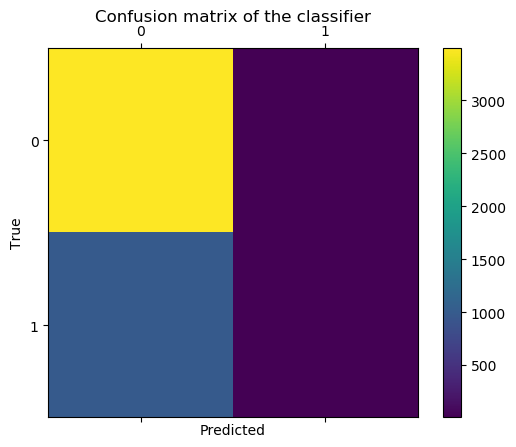

In [66]:
# Confusion Matrix
# from sklearn.metrics import confusion_matrix
labels = [0, 1]
print("LABELS[0 , 1] = [No_Default, Default]")
cm = confusion_matrix(y_test, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()